Project: /overview/_project.yaml
Book: /overview/_book.yaml

<devsite-mathjax config="TeX-AMS-MML_SVG"></devsite-mathjax>
<link rel="stylesheet" href="/site-assets/css/style.css">

<!-- DO NOT EDIT! Automatically generated file. -->


{% comment %}
The source of truth file can be found [here]: http://google3/zz
{% endcomment %}

<div itemscope itemtype="http://developers.google.com/ReferenceObject">
<meta itemprop="name" content="基本的なトレーニングループ" />
<meta itemprop="path" content="Guide & Tutorials" />
<meta itemprop="property" content="tf.GradientTape"/>
<meta itemprop="property" content="tf.Module"/>
<meta itemprop="property" content="tf.Variable"/>
<meta itemprop="property" content="tf.cast"/>
<meta itemprop="property" content="tf.keras.Model"/>
<meta itemprop="property" content="tf.keras.optimizers.experimental.SGD"/>
<meta itemprop="property" content="tf.linspace"/>
<meta itemprop="property" content="tf.math.reduce_mean"/>
<meta itemprop="property" content="tf.math.square"/>
<meta itemprop="property" content="tf.random.normal"/>
</div>

# 基本的なトレーニングループ

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/basic_training_loops"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a>   </td>
</table>

以前のガイドでは、[テンソル](./tensor.ipynb)、[変数](./variable.ipynb)、[勾配テープ](autodiff.ipynb)、[モジュール](./intro_to_modules.ipynb)について学習しました。このガイドでは、これらをすべて組み合わせてモデルをトレーニングします。

TensorFlow には、[tf.Keras API](https://www.tensorflow.org/guide/keras/overview) という、抽象化によってボイラープレートを削減する高度なニューラルネットワーク API も含まれていますが、このガイドでは基本的なクラスを使用します。

## セットアップ

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

2022-12-14 20:41:02.508484: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:41:02.508574: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:41:02.508583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 機械学習問題を解決する

機械学習問題を解決する場合、一般的には次の手順を実行します。

- トレーニングデータを取得する。
- モデルを定義する。
- 損失関数を定義する。
- トレーニングデータを読み込み、理想値から損失を計算する。
- その損失の勾配を計算し、*オプティマイザ*を使用してデータに適合するように変数を調整します。
- 結果を評価する。

説明のため、このガイドでは $W$（重み）と $b$（バイアス）の 2 つの変数を持つ単純な線形モデルである $f(x) = x * W + b$ を開発します。

これは最も基本的な機械学習問題です。$x$ と $y$ が与えられている前提で  [単純線形回帰](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regression)を使用して直線の傾きとオフセットを求めてみます。

## データ

教師あり学習では、*入力*（通常は *x* と表記）と*出力*（*y* と表記され、*ラベル*と呼ばれることが多い）を使用します。目標は、入力と出力のペアから学習し、入力から出力の値を予測できるようにすることです。

TensorFlow での各データ入力はほぼ必ずテンソルで表現され、多くの場合はベクトルです。教師ありトレーニングの場合は出力（または予測したい値）もテンソルになります。

以下は、直線上の点にガウス（正規）ノイズを付加することによって合成されたデータです。

In [3]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2,2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

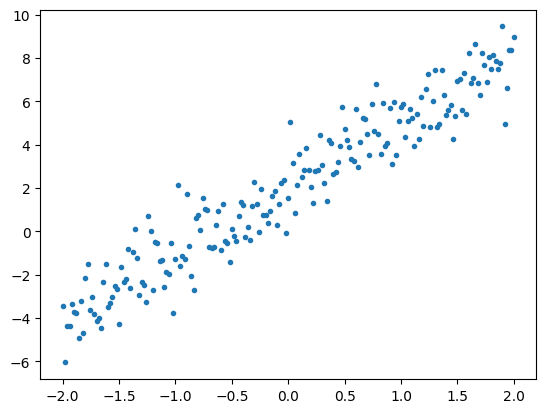

In [4]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

テンソルは一般的に*バッチ*か、入力と出力のグループにまとめられます。バッチにはいくつかのトレーニング上のメリットがあり、アクセラレーターやベクトル化計算でうまく機能します。このデータセットの小ささを考慮すると、データセット全体を単一のバッチとして扱うことができます。

## モデルを定義する

モデル内のすべての重みを表現するには <a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a> を使用します。<a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a> は値を格納し、必要に応じてこれをテンソル形式で提供します。詳細については、[変数ガイド](./variable.ipynb)を参照してください。

変数と計算のカプセル化には <a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a> を使用します。任意の Python オブジェクトを使用することもできますが、この方法ではより簡単に保存できます。

ここでは *w* と *b* の両方を変数として定義しています。

In [5]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


ここでは初期変数が固定されていますが、Keras には他の Keras の有無にかかわらず使用できる多くの[初期化子](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)があります。

### 損失関数を定義する

損失関数は、特定の入力に対するモデルの出力と目標出力との一致度を評価します。目標は、トレーニング中のこの差を最小限に抑えることです。 「平均二乗」誤差としても知られる標準 L2 損失を定義します。

In [6]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

モデルをトレーニングする前に、モデルの予測を赤でプロットし、トレーニングデータを青でプロットすることにより、損失の値を視覚化できます。

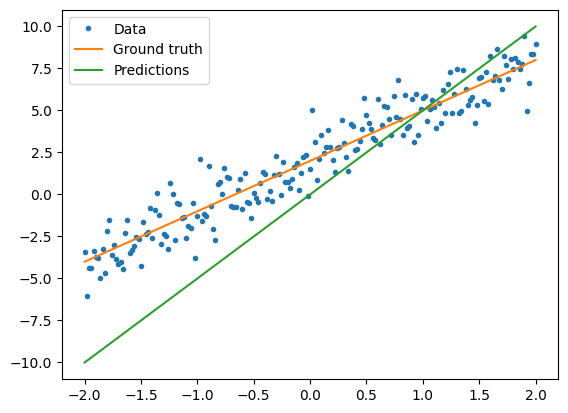

Current loss: 10.299762


In [7]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

### トレーニングループを定義する

トレーニングループは、次の 3 つを順番に繰り返し実行するタスクで構成されます。

- モデル経由で入力のバッチを送信して出力を生成する
- 出力を出力（またはラベル）と比較して損失を計算する
- 勾配テープを使用して勾配を検出する
- これらの勾配を使用して変数を最適化する

この例では、[最急降下法](https://en.wikipedia.org/wiki/Gradient_descent)を使用してモデルをトレーニングできます。

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers"><code>tf.keras.optimizers</code></a> でキャプチャされる勾配降下法のスキームには多くのバリエーションがありますが、ここでは基本原理から構築するという姿勢で自動微分を行う <a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape"><code>tf.GradientTape</code></a> と値を減少させる `tf.assign_sub`（`tf.assign` と `tf.sub` の組み合わせ）を使用して基本的な計算を自分で実装してみましょう。

In [8]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

トレーニングを観察するため、トレーニングループを介して *x* と *y* の同じバッチを送信し、`W` と `b` がどのように変化するかを見ることができます。

In [9]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
  return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"


def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    weights.append(model.w.numpy())
    biases.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))

Do the training。

In [10]:
current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)

Starting:
     W = 5.00, b = 0.00, loss=10.29976


Epoch  0:
     W = 4.48, b = 0.40, loss=6.46287
Epoch  1:
     W = 4.09, b = 0.72, loss=4.26008
Epoch  2:
     W = 3.81, b = 0.98, loss=2.98527
Epoch  3:
     W = 3.61, b = 1.19, loss=2.24146
Epoch  4:
     W = 3.46, b = 1.35, loss=1.80388
Epoch  5:
     W = 3.35, b = 1.48, loss=1.54438
Epoch  6:
     W = 3.27, b = 1.59, loss=1.38926
Epoch  7:
     W = 3.21, b = 1.67, loss=1.29584
Epoch  8:
     W = 3.17, b = 1.74, loss=1.23917
Epoch  9:
     W = 3.14, b = 1.79, loss=1.20457


経時的な重みの変化をプロットします。

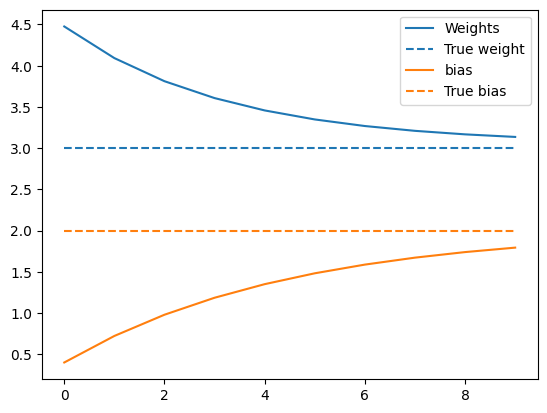

In [11]:
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

トレーニングされたモデルのパフォーマンスを視覚化します。

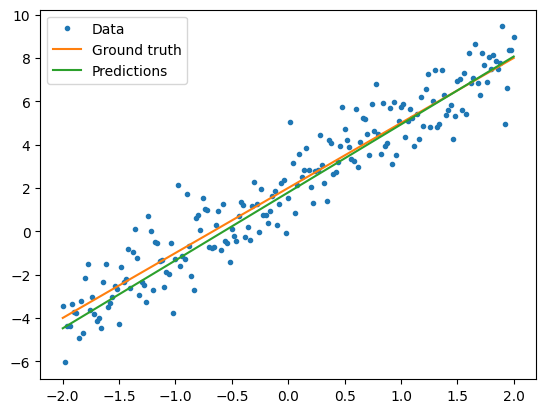

Current loss: 1.204573


In [12]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

## Keras を使用した場合の同じ方法

上記のコードを Keras で書いたコードと対比すると参考になります。

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model"><code>tf.keras.Model</code></a> をサブクラス化すると、モデルの定義はまったく同じように見えます。Keras モデルは最終的にモジュールから継承するということを覚えておいてください。

In [13]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("my_checkpoint")

Epoch  0:
     W = 4.48, b = 0.40, loss=6.46287
Epoch  1:
     W = 4.09, b = 0.72, loss=4.26008
Epoch  2:
     W = 3.81, b = 0.98, loss=2.98527
Epoch  3:
     W = 3.61, b = 1.19, loss=2.24146
Epoch  4:
     W = 3.46, b = 1.35, loss=1.80388
Epoch  5:
     W = 3.35, b = 1.48, loss=1.54438
Epoch  6:
     W = 3.27, b = 1.59, loss=1.38926
Epoch  7:
     W = 3.21, b = 1.67, loss=1.29584
Epoch  8:
     W = 3.17, b = 1.74, loss=1.23917
Epoch  9:
     W = 3.14, b = 1.79, loss=1.20457


モデルを作成するたびに新しいトレーニングループを作成する代わりに、Keras の組み込み機能をショートカットとして使用できます。これは、Python トレーニングループを作成またはデバッグしたくない場合に便利です。

その場合は `model.compile()` を使用してパラメーターを設定し、`model.fit()` でトレーニングする必要があります。L2 損失と最急降下法の Keras 実装を再びショートカットとして使用するとコード量を少なくすることができます。Keras の損失とオプティマイザーはこれらの便利な関数の外でも使用できます。また、前の例ではこれらを使用できた可能性があります。

In [14]:
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

Keras `fit` は、バッチ処理されたデータまたは完全なデータセットを NumPy 配列として想定しています。NumPy 配列はバッチに分割され、デフォルトでバッチサイズは 32 になります。

この場合は手書きループの動作に一致させるため、`x` をサイズ 1000 の単一バッチとして渡す必要があります。

In [15]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

201
Epoch 1/10


1/1 [==============================] - 0s 369ms/step - loss: 10.2998


Epoch 2/10


1/1 [==============================] - 0s 5ms/step - loss: 6.4629


Epoch 3/10


1/1 [==============================] - 0s 4ms/step - loss: 4.2601


Epoch 4/10


1/1 [==============================] - 0s 4ms/step - loss: 2.9853


Epoch 5/10


1/1 [==============================] - 0s 4ms/step - loss: 2.2415


Epoch 6/10


1/1 [==============================] - 0s 4ms/step - loss: 1.8039


Epoch 7/10


1/1 [==============================] - 0s 4ms/step - loss: 1.5444


Epoch 8/10


1/1 [==============================] - 0s 4ms/step - loss: 1.3893


Epoch 9/10


1/1 [==============================] - 0s 4ms/step - loss: 1.2958


Epoch 10/10


1/1 [==============================] - 0s 4ms/step - loss: 1.2392


Keras はトレーニング前ではなくトレーニング後に損失を出力するため、最初の損失は低く表示されますが、それ以外の場合は基本的に同じトレーニングパフォーマンスを示します。

## 次のステップ

このガイドでは、テンソル、変数、モジュール、勾配テープの基本的なクラスを使用してモデルを構築およびトレーニングする方法と、それらの概念を Keras にマッピングする方法について説明しました。

ただし、これはごく単純な問題です。より実践的な説明については、[カスタムトレーニングのウォークスルー](../tutorials/customization/custom_training_walkthrough.ipynb)をご覧ください。

組み込みの Keras トレーニングループを使用する方法の詳細は、[こちらのガイド](https://www.tensorflow.org/guide/keras/train_and_evaluate)を参照してください。トレーニングループと Keras の詳細は、[こちらのガイド](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)を参照してください。独自の分散トレーニングループを書く方法については、[こちらのガイド](distributed_training.ipynb#using_tfdistributestrategy_with_basic_training_loops_loops)を参照してください。